In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import json
from yahoofinancials import YahooFinancials as YF
import time
from datetime import datetime
import pandas as pd
from pandas_datareader import data
from typing import List, Optional
import os
import pickle 
from tqdm import tqdm
from pydantic import BaseModel
import scipy.stats as sp
from utils import *
from backtester import *
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 1000})
import math
import yfinance as yf # https://github.com/ranaroussi/yfinance
from pandas_datareader import data as pdr

In [2]:
c_or_p = 'c'
price = 42
strike = 50
risk_free_rate = 4
days = 20
volatility = 20
a = BsmModel(c_or_p, float(price), float(strike), float(risk_free_rate), float(days)/365, float(volatility))
a.bsm_price()

41.209805172631775

In [3]:
tickers = ['MMM', 'GOOG', 'AMD']
days_back = 100
with open("./stocks.pkl", "rb") as pkl_handle:
    bars = pickle.load(pkl_handle)
#bars = getStockData(tickers, days_back)

AttributeError: Can't get attribute 'new_block' on <module 'pandas.core.internals.blocks' from 'C:\\Users\\moyer\\OneDrive\\development\\fintech\\quant\\lib\\site-packages\\pandas\\core\\internals\\blocks.py'>

In [4]:
bars['MMM']

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-03-19,191.000000,188.690002,190.600006,188.710007,6678900.0,187.331482
2021-03-22,189.759995,187.009995,188.259995,189.470001,2605300.0,188.085922
2021-03-23,191.710007,187.899994,188.770004,188.330002,2768700.0,186.954239
2021-03-24,192.740005,188.080002,188.429993,190.690002,2829200.0,189.297012
2021-03-25,193.360001,190.169998,191.639999,193.100006,2221000.0,191.689407
...,...,...,...,...,...,...
2021-06-21,196.630005,193.589996,193.589996,195.210007,2528400.0,195.210007
2021-06-22,196.050003,194.100006,194.750000,195.139999,1772600.0,195.139999
2021-06-23,195.419998,192.279999,194.800003,192.360001,2976500.0,192.360001


In [4]:
def getStocks(tickers, days_back):
    def convert_time(epoch):
        return time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(epoch))
    
    epoch_time = int(time.time())
    day_epoch = 60*60*24
    # tickers = df['Symbol'][:10]
    stocks = {}
    for tick in tqdm(tickers):
        try:
            stock_data = data.DataReader(tick, 
                            start=convert_time(epoch_time - (int(days_back)* day_epoch)), 
                            end=convert_time(epoch_time), 
                            data_source='yahoo')
            stocks[tick] = stock_data 
        except:
            print("Skipping stock for {}, bad data :<".format(tick))
    return stocks


In [5]:
tickers = ['MMM', 'GOOG', 'AMD']
days_back = 100
stocks = getStocks(tickers, days_back)

 33%|███▎      | 1/3 [00:02<00:05,  2.89s/it]

Skipping stock for MMM, bad data :<


 67%|██████▋   | 2/3 [00:05<00:02,  2.90s/it]

Skipping stock for GOOG, bad data :<


100%|██████████| 3/3 [00:08<00:00,  2.88s/it]

Skipping stock for AMD, bad data :<


In [30]:
stocks.keys()

dict_keys(['MMM', 'GOOG', 'AMD'])

'C:\\Users\\moyer\\OneDrive\\development\\fin-dashboard\\app'

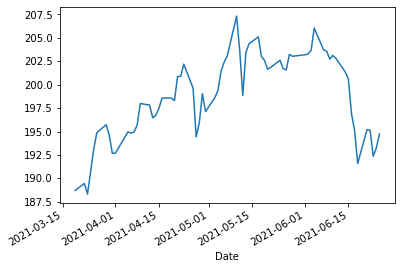

In [45]:
import os
stocks['MMM']['Close'].plot()
os.getcwd()

In [32]:
# SAVE
with open("stocks.pkl", "wb") as pkl_handle:
    pickle.dump(stocks, pkl_handle)

In [6]:
# LOAD
bars ={}
with open("stocks.pkl", "rb") as pkl_handle:
    bars = pickle.load(pkl_handle)
bars['MMM'].head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-03-19,191.000000,188.690002,190.600006,188.710007,6678900.0,187.331482
2021-03-22,189.759995,187.009995,188.259995,189.470001,2605300.0,188.085922
2021-03-23,191.710007,187.899994,188.770004,188.330002,2768700.0,186.954239
2021-03-24,192.740005,188.080002,188.429993,190.690002,2829200.0,189.297012
2021-03-25,193.360001,190.169998,191.639999,193.100006,2221000.0,191.689407


In [7]:
T = 2
K_date = '2021-06-11'
K = 190
S_init = 40
S_current = 180
long = True
call = True
price = 3

def getPayoff(S_current, K, long, call):
    if (call):
        if (long):
            return max(S_current - K, 0)
        else:
            return max(K - S_current, 0)
    else:
        if (long):
            return max(K - S_current, 0)
        else:
            return max(S_current - K, 0)
        
def getProfit(S_current, K, long, call, price):
    if (call):
        if (long):
            return max(S_current - K, 0) - price
        else:
            return max(K - S_current, 0) - price
    else:
        if (long):
            return max(K - S_current, 0) - price
        else:
            return max(S_current - K, 0) - price
        
print(getPayoff(S_current, K, long, call))
print(getProfit(S_current, K, long, call, price))

0
-3


In [10]:
import yfinance as yf # sssss
from pandas_datareader import data as pdsssssssssssssr

import yfinance as yf
yf.pdr_override() # <== that's all it takes :-)

# download dataframe
data = pdr.get_data_yahoo("SPY", start="2017-01-01", end="2017-04-30")

[*********************100%***********************]  1 of 1 completed


In [11]:
msft = yf.Ticker("MSFT")

# get stock info
msft.info

# get historical market data
hist = msft.history(period="max")

# show actions (dividends, splits)
msft.actions

# show dividends
msft.dividends

# show splits
msft.splits

# show financials
msft.financials
msft.quarterly_financials

# show major holders
msft.major_holders

# show institutional holders
msft.institutional_holders

# show balance sheet
msft.balance_sheet
msft.quarterly_balance_sheet

# show cashflow
msft.cashflow
msft.quarterly_cashflow

# show earnings
msft.earnings
msft.quarterly_earnings

# show sustainability
msft.sustainability

# show analysts recommendations
msft.recommendations

# show next event (earnings, etc)
msft.calendar

# show ISIN code - *experimental*
# ISIN = International Securities Identification Number
msft.isin

# show options expirations
msft.options

# get option chain for specific expiration
#opt = msft.option_chain('2021-05-28')

('2021-07-02',
 '2021-07-09',
 '2021-07-16',
 '2021-07-23',
 '2021-07-30',
 '2021-08-06',
 '2021-08-20',
 '2021-09-17',
 '2021-10-15',
 '2021-11-19',
 '2022-01-21',
 '2022-03-18',
 '2022-06-17',
 '2022-09-16',
 '2023-01-20',
 '2023-03-17',
 '2023-06-16')

In [12]:
# msft = yf.Ticker("MSFT")
# opt = msft.option_chain(msft.options[0])
# DF_calls, DF_puts = msft.option_chain(msft.options[0]) # returns 2 DataFrames
# print(msft.options)
# DF_calls


def getOptionValues(ticker, date):
    data = yf.Ticker(ticker)
    DF_calls, DF_puts = data.option_chain(msft.options[0]) # returns 2 DataFrames
    return DF_calls, DF_puts

def getOptionDates(ticker):
    data = yf.Ticker(ticker)
    return data.options

print(getOptionDates('MMM'))
ticker = 'GOOG'
dates = getOptionDates(ticker)
calls, puts = getOptionValues(ticker, dates[0])
calls.head()

('2021-07-02', '2021-07-09', '2021-07-16', '2021-07-23', '2021-07-30', '2021-08-06', '2021-08-20', '2021-10-15', '2022-01-21', '2023-01-20')


,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,GOOG210702C01300000,2021-06-28 18:51:34,1300.0,1235.90,1201.5,1216.3,0.000000,0.00000,2.0,1,4.024907,True,REGULAR,USD
1,GOOG210702C01340000,2021-06-23 17:26:52,1340.0,1199.55,1157.0,1176.1,0.000000,0.00000,2.0,2,2.935550,True,REGULAR,USD
2,GOOG210702C01350000,2021-06-29 16:08:13,1350.0,1155.75,1147.5,1166.0,-11.699951,-1.00218,1.0,1,3.084963,True,REGULAR,USD
3,GOOG210702C01440000,2021-06-21 19:54:55,1440.0,1094.70,1057.5,1076.3,0.000000,0.00000,NaN,0,2.874026,True,REGULAR,USD
4,GOOG210702C01650000,2021-06-18 17:50:59,1650.0,856.33,847.0,866.4,0.000000,0.00000,1.0,1,2.120122,True,REGULAR,USD


In [13]:
# calls.iloc[0]['strike']
calls[calls['inTheMoney'] == True]

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,GOOG210702C01300000,2021-06-28 18:51:34,1300.0,1235.90,1201.5,1216.3,0.000000,0.000000,2.0,1,4.024907,True,REGULAR,USD
1,GOOG210702C01340000,2021-06-23 17:26:52,1340.0,1199.55,1157.0,1176.1,0.000000,0.000000,2.0,2,2.935550,True,REGULAR,USD
2,GOOG210702C01350000,2021-06-29 16:08:13,1350.0,1155.75,1147.5,1166.0,-11.699951,-1.002180,1.0,1,3.084963,True,REGULAR,USD
3,GOOG210702C01440000,2021-06-21 19:54:55,1440.0,1094.70,1057.5,1076.3,0.000000,0.000000,NaN,0,2.874026,True,REGULAR,USD
4,GOOG210702C01650000,2021-06-18 17:50:59,1650.0,856.33,847.0,866.4,0.000000,0.000000,1.0,1,2.120122,True,REGULAR,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,GOOG210702C02495000,2021-06-30 16:25:59,2495.0,21.10,15.0,23.6,-9.500000,-31.045750,31.0,107,0.235024,True,REGULAR,USD
96,GOOG210702C02497500,2021-06-30 18:10:51,2497.5,16.00,13.5,22.6,-12.500000,-43.859650,52.0,0,0.241508,True,REGULAR,USD
97,GOOG210702C02500000,2021-06-30 19:54:10,2500.0,20.00,15.7,21.5,-9.190001,-31.483385,295.0,0,0.245735,True,REGULAR,USD
98,GOOG210702C02502500,2021-06-30 19:54:33,2502.5,17.16,10.5,18.3,-8.639999,-33.488373,119.0,0,0.220650,True,REGULAR,USD


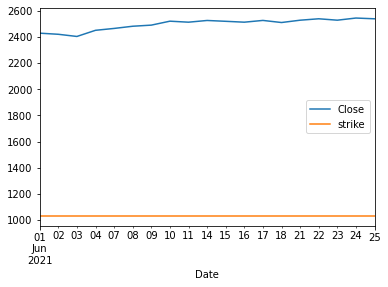

In [52]:
df = bars[ticker]
start = '2021-06-01'
maturity = '2021-06-25'
option_i = 0
df['option_profit']=df.apply(lambda x: getProfit(x['Close'], 200, True, True, 30),axis=1)
df['option_payoff']=df.apply(lambda x: getPayoff(x['Close'], 204, True, True),axis=1)
df['strike']=df.apply(lambda x: getPayoff(x['strike'], 204, True, True),axis=1)
df.tail()
df = df.loc[start:maturity]
df[['Close', 'strike']].plot()
#df.Close.plot(style='r-', secondary_y=True)

1300.0
1340.0
1350.0
1440.0


C:\Users\moyer\OneDrive\development\fintech\quant\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
C:\Users\moyer\OneDrive\development\fintech\quant\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\moyer\OneDrive\development\fintech\quant\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

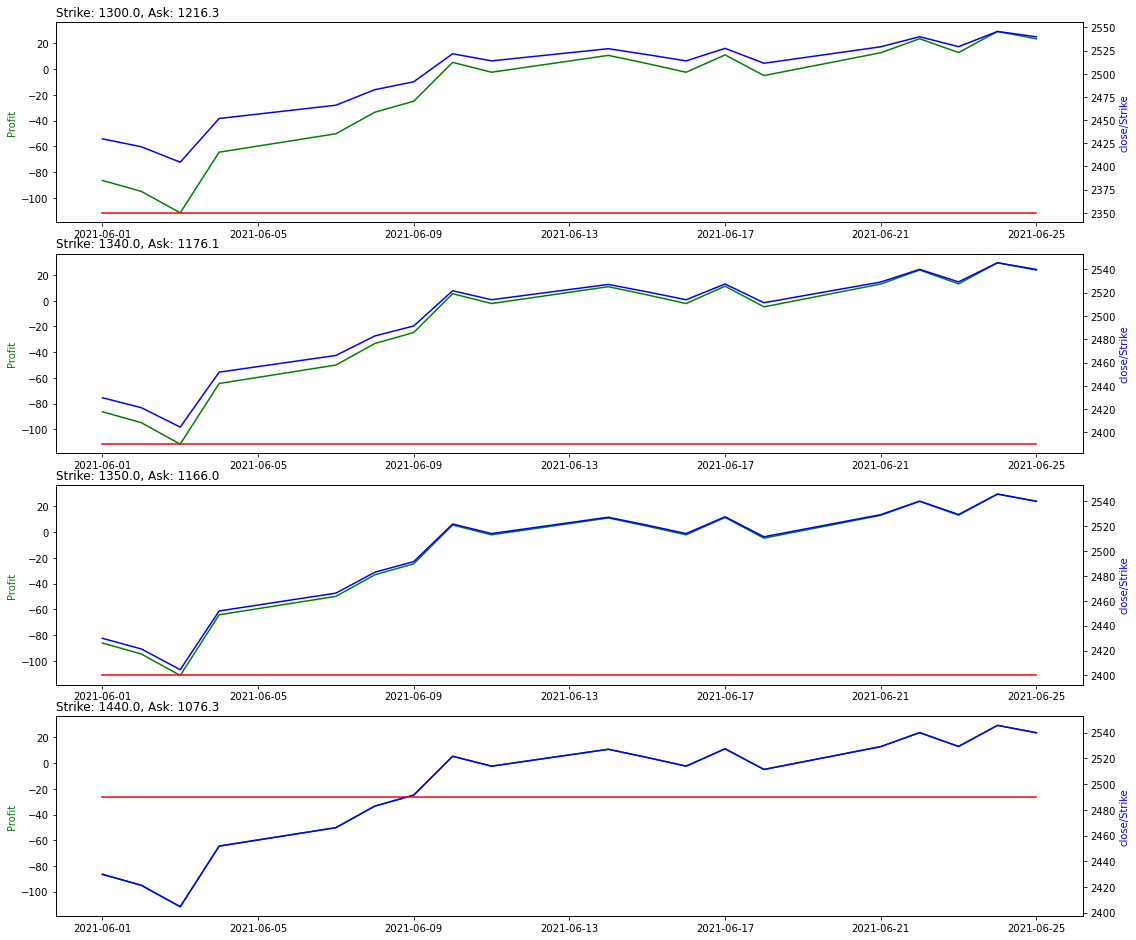

In [57]:
#fig, axes = plt.subplots(nrows=2, ncols=2)
# df1.plot(ax=axes[0,0])
# df2.plot(ax=axes[0,1])

n_plots = 4 
fig, axs = plt.subplots(n_plots,figsize=(15,13))
fig.tight_layout()
ax2 = []
df = bars[ticker]
start = '2021-06-01'
maturity = '2021-06-25'
plots = []
#fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(13,10))
for index, row in calls[calls['inTheMoney'] == True][0:n_plots].iterrows():
    #print('Strike: {}, Ask: {}'.format(row['strike'],row['ask']))
    df['option_profit']=df.apply(lambda x: getProfit(x['Close'], row['strike'], True, True, row['ask']),axis=1)
    df['option_payoff']=df.apply(lambda x: getPayoff(x['Close'], row['strike'], True, True),axis=1)
    df['strike'] = row['strike'] + 1050
    print(row['strike'])
    df = df.loc[start:maturity]
    #df['Close'].plot()
#     fig, ax1 = plt.subplots()

#     ax2 = ax1.twinx()
#     ax1.plot(x, y1, 'g-')
#     ax2.plot(x, y2, 'b-')

#     ax1.set_xlabel('X data')
#     ax1.set_ylabel('Y1 data', color='g')
#     ax2.set_ylabel('Y2 data', color='b')

    # also figsize=(13,10)
#     df[['option_profit', 'option_payoff']].plot()
#     df[['Close','strike']].plot(style='-', color=['purple', 'red'],secondary_y=True,title='Strike: {}, Ask: {}'.format(row['strike'],row['ask']));
#     ax2 = ax1.twinx()
#     ax1.plot(df[['Close','strike']])
#     ax1.set_ylabel("close/Strike", color='g')
    
#     ax2.plot(df[['option_profit', 'option_payoff']])
#     ax2.set_ylabel('Profit/Payoff', color='b')
#     df[['option_profit', 'option_payoff']].plot()
#     df[['Close','strike']].plot(style='r-', secondary_y=True,title='Strike: {}, Ask: {}'.format(row['strike'],row['ask']))
    axs[index].set_title('Strike: {}, Ask: {}'.format(row['strike'],row['ask']), loc='left')
    axs[index].plot(df[['option_profit']], color='green')
    axs[index].set_ylabel('Profit', color='green')
    ax2.append(axs[index].twinx())
    #ax2.plot(df[['Close','strike']])
    ax2[index].plot(df['Close'],color = 'blue')
    ax2[index].plot(df['strike'], color = 'red',label = 'Strike')
    ax2[index].set_ylabel("close/Strike", color='blue')


In [78]:
import matplotlib as plt


In [8]:
initial_captial = 10000
signals = pd.DataFrame()
portfolio = MyPortfolio(tickers, bars, signals, initial_captial)

In [10]:
forecast = portfolio.forecast_portfolio()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [13]:
forecast['MMM']

,yhat,yhat_upper,yhat_lower
ds,,,
2021-05-14,203.737563,206.014612,201.503868
2021-05-15,203.993201,206.013029,201.984687
2021-05-16,204.453351,206.800496,202.389599
2021-05-17,205.654201,208.028549,203.409826
2021-05-18,205.637142,207.955049,203.337355
2021-05-19,205.311287,207.532115,203.091404
2021-05-20,206.102678,208.360480,203.890355
2021-05-21,204.727181,206.958410,202.400324
2021-05-22,206.469024,208.883702,204.028235
